# Sentiment Analysis Using RNN

# Importing libraries <a id="1"></a>

In [ ]:
# DataFrame
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

# Loading Dataset <a id="2"></a>

In [ ]:
# Construct a tf.data.Dataset
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])

In [ ]:
data = data.sample(frac=1)
data = data[:200000]

# Data Visualization <a id="3"></a>

In [ ]:
print("Dataset shape:", data.shape)

Dataset shape: (200000, 6)


In [ ]:
data.head(10)

,polarity,id,date,query,user,text
552255,0,2203356712,Tue Jun 16 23:33:37 PDT 2009,NO_QUERY,MandySydelle,someone named &quot;horny hottie&quot; is foll...
712771,0,2258634202,Sat Jun 20 16:14:44 PDT 2009,NO_QUERY,lyshaxmichele,Is feeling better than before after this nice ...
1259118,4,1998047766,Mon Jun 01 17:54:17 PDT 2009,NO_QUERY,PhannieTV,See ya twitter! PEACE OUT!!
630727,0,2232086088,Thu Jun 18 19:25:57 PDT 2009,NO_QUERY,Pamluvsthebeach,Doesn't it suck to realize that you are marrie...
910289,4,1751537869,Sat May 09 19:41:00 PDT 2009,NO_QUERY,jillhanner,my mom watched my new video and she actually L...
225606,0,1977673346,Sat May 30 21:27:25 PDT 2009,NO_QUERY,tattooedchick13,@Popcorn78 haha you should be lol it was fun B...
1299533,4,2006148310,Tue Jun 02 10:43:51 PDT 2009,NO_QUERY,clarioncall,@ButifulDeath Click this and feel it. http://...
143303,0,1881690748,Fri May 22 05:19:32 PDT 2009,NO_QUERY,AnnieVigilante,this wicked friendly marine with a sad story j...
755258,0,2288266978,Mon Jun 22 18:56:21 PDT 2009,NO_QUERY,skeeterbop,@bls16 Deal support wants you to totally rebu...
883020,4,1686060197,Sun May 03 03:32:46 PDT 2009,NO_QUERY,peterrowlett,"@NoelAnn Hi Noel-Ann, If you use someone's use..."


In [ ]:
data['polarity'].unique()

array([0, 4])

In [ ]:
# Replacing the value 4 -->1 for ease of understanding.
data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
552255,0,2203356712,Tue Jun 16 23:33:37 PDT 2009,NO_QUERY,MandySydelle,someone named &quot;horny hottie&quot; is foll...
712771,0,2258634202,Sat Jun 20 16:14:44 PDT 2009,NO_QUERY,lyshaxmichele,Is feeling better than before after this nice ...
1259118,1,1998047766,Mon Jun 01 17:54:17 PDT 2009,NO_QUERY,PhannieTV,See ya twitter! PEACE OUT!!
630727,0,2232086088,Thu Jun 18 19:25:57 PDT 2009,NO_QUERY,Pamluvsthebeach,Doesn't it suck to realize that you are marrie...
910289,1,1751537869,Sat May 09 19:41:00 PDT 2009,NO_QUERY,jillhanner,my mom watched my new video and she actually L...


In [ ]:
data.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,0.499450,1.998790e+09
std,0.500001,1.934361e+08
min,0.000000,1.467814e+09
25%,0.000000,1.956880e+09
50%,0.000000,2.001987e+09
75%,1.000000,2.177036e+09
max,1.000000,2.329205e+09


In [ ]:
# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         200000
No. of positve tagged sentences is:  99890
No. of negative tagged sentences is: 100110


In [ ]:
# get a word count per of text
def word_count(words):
    return len(words.split())

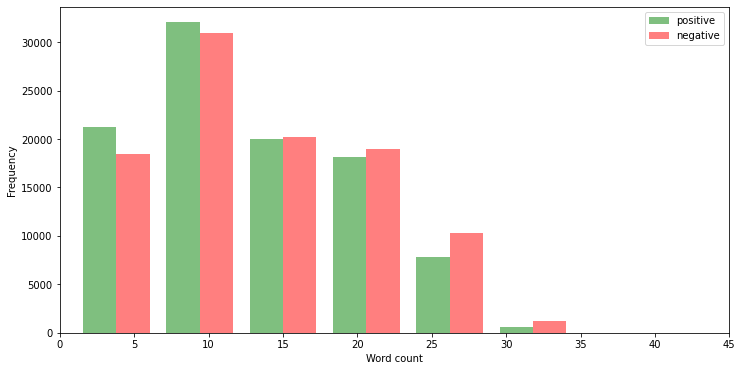

In [ ]:
# plot word count distribution for both positive and negative

data['word count'] = data['text'].apply(word_count)
p = data['word count'][data.polarity == 1]
n = data['word count'][data.polarity == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [ ]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())


Counter(all_words).most_common(20)

[('the', 65286),
 ('and', 36828),
 ('you', 29761),
 ('for', 26644),
 ('have', 17928),
 ('that', 16153),
 ("i'm", 16098),
 ('but', 15753),
 ('just', 15385),
 ('with', 14211),
 ('was', 12892),
 ('not', 12707),
 ('this', 10885),
 ('get', 9982),
 ('good', 9656),
 ('are', 9557),
 ('like', 9529),
 ('all', 9190),
 ('out', 8754),
 ('your', 8117)]

# Data Processing <a id="4"></a>

<AxesSubplot:xlabel='polarity', ylabel='count'>

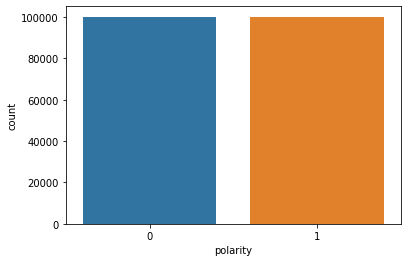

In [ ]:
%matplotlib inline
sns.countplot(data['polarity'])

In [ ]:
# Removing the unnecessary columns.
data.drop(['date','query','user','word count'], axis=1, inplace=True)

In [ ]:
data.drop('id', axis=1, inplace=True)

In [ ]:
data.head(10)

,polarity,text
552255,0,someone named &quot;horny hottie&quot; is foll...
712771,0,Is feeling better than before after this nice ...
1259118,1,See ya twitter! PEACE OUT!!
630727,0,Doesn't it suck to realize that you are marrie...
910289,1,my mom watched my new video and she actually L...
225606,0,@Popcorn78 haha you should be lol it was fun B...
1299533,1,@ButifulDeath Click this and feel it. http://...
143303,0,this wicked friendly marine with a sad story j...
755258,0,@bls16 Deal support wants you to totally rebu...
883020,1,"@NoelAnn Hi Noel-Ann, If you use someone's use..."


In [ ]:
#Checking if any null values present
(data.isnull().sum() / len(data))*100

polarity    0.0
text        0.0
dtype: float64

In [ ]:
#convrting pandas object to a string type
data['text'] = data['text'].astype('str')

In [ ]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{"i'd", 'hadn', "you've", 'who', "couldn't", "we'll", 'just', 'which', 'before', 'are', 'its', 'being', 'no', 'too', "i'm", 'has', 'don', "wouldn't", 'the', 'against', 'than', 'does', 'he', "needn't", "weren't", 'between', 'by', 'each', 'have', 'now', 'some', 'you', 'y', "he'll", 'wouldn', 'this', 'further', 'so', 'then', 'as', "isn't", "you're", "hasn't", 'needn', 'ma', 'o', 'them', 'she', "they'd", 'until', "she'd", 'isn', 'hers', 'here', 've', 'am', 'his', 'an', 'in', 'do', "we'd", 'all', 'or', 'same', "hadn't", 'be', "i've", 'whom', 'that', 'theirs', 'my', "they'll", 'we', 'it', "won't", 'with', 'mightn', 'to', 'doing', "shan't", 'over', 'me', 'any', "they've", 'these', 'once', "we're", "she'll", 'him', 'should', 'a', "it'll", "i'll", "should've", 'did', 'didn', 'if', 'himself', 'wasn', "it's", 'after', 'had', "haven't", 'how', 'such', "he'd", 'mustn', 'was', 'her', "

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet)
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [ ]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


## Vectorization and Splitting the data <a id="6"></a>
Storing input variable-processes_tweets to X and output variable-polarity to y

In [ ]:
X = data['processed_tweets'].values
y = data['polarity'].values


In [ ]:
print(X.shape)
print(y.shape)

(200000,)
(200000,)


In [ ]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names()))

Vector fitted.
No. of feature_words:  170417


In [ ]:
print(X.shape)
print(y.shape)

(200000, 170417)
(200000,)


# RNN <a id="12"></a>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re

In [ ]:
import keras
keras.__version__

'2.4.3'

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences = tokenizer.texts_to_sequences(data.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ... 1446 2288  318]
 [   0    0    0 ... 1122  494    3]
 [   0    0    0 ...  196   41  971]
 ...
 [   0    0    0 ...    0  325    9]
 [   0    0    0 ... 1144   61 1748]
 [   0    0    0 ...   22  457   41]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data.polarity.values, test_size=0.2, random_state=101)

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 200)
y_train (160000,)

X_test (40000, 200)
y_test (40000,)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

model2 = Sequential()
model2.add(layers.Embedding(max_words, 64))
model2.add(layers.LSTM(32, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
model2.add(layers.LSTM(16, dropout=0.3))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint2 = ModelCheckpoint("rnn_model.hdf55", monitor='val_accuracy', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model2.fit(X_train, y_train, epochs=20, batch_size=64,
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint2, early_stopping])


Epoch 1/20
2500/2500 [==============================] - 50s 19ms/step - loss: 0.5508 - accuracy: 0.7124 - val_loss: 0.4871 - val_accuracy: 0.7627

Epoch 00001: val_accuracy improved from -inf to 0.76267, saving model to rnn_model.hdf55
Epoch 2/20
2500/2500 [==============================] - 46s 18ms/step - loss: 0.4737 - accuracy: 0.7726 - val_loss: 0.4791 - val_accuracy: 0.7702

Epoch 00002: val_accuracy improved from 0.76267 to 0.77017, saving model to rnn_model.hdf55
Epoch 3/20
2500/2500 [==============================] - 46s 18ms/step - loss: 0.4650 - accuracy: 0.7774 - val_loss: 0.4791 - val_accuracy: 0.7711

Epoch 00003: val_accuracy improved from 0.77017 to 0.77115, saving model to rnn_model.hdf55
Epoch 4/20
2500/2500 [==============================] - 46s 18ms/step - loss: 0.4555 - accuracy: 0.7842 - val_loss: 0.4869 - val_accuracy: 0.7682

Epoch 00004: val_accuracy did not improve from 0.77115
Epoch 5/20
2500/2500 [==============================] - 47s 19ms/step - loss: 0.4469

# Plotting <a id="13"></a>

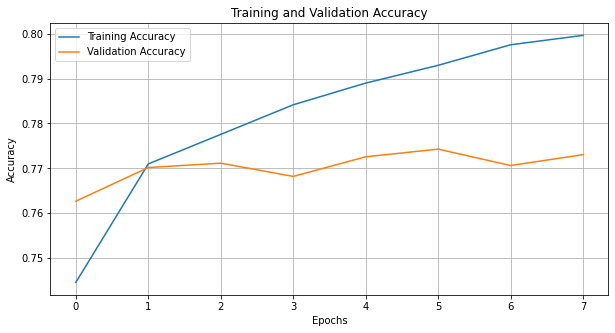

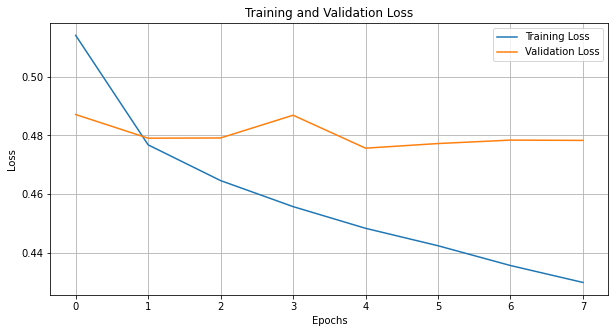

In [ ]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint

# 📊 Plotting training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 📉 Plotting training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Model Saving, Loading and Prediction <a id="13"></a>

In [ ]:
sequence = tokenizer.texts_to_sequences(['this data science article is the worst ever'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model2.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')
print(pred)

Negative
[[0.22831279]]


In [ ]:
loaded_model = keras.models.load_model('rnn_model.hdf5')
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
pred = loaded_model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

Positive


In [ ]:
sequence2 = tokenizer.texts_to_sequences(['I had a bad day at work.'])
test2 = pad_sequences(sequence2, maxlen=max_len)
pred2 = loaded_model.predict(test2)
if pred2 > 0.5:
  print('Positive')
else:
  print('Negative')

Negative
